# Dataset Balancing Methods

## Purpose: Stroke Prediction

According to the NIH National Heart, Lung, and Blood Institute (HHLI):

>Strokes are caused by blocked blood flow to the brain (ischemic stroke) or sudden bleeding in the brain (hemorrhagic stroke). Many things raise your risk of stroke, and many of these can be changed to help prevent a stroke or prevent another stroke.

The aim of this analysis is to compare different models' accuracy when predicting a stroke based on key health factors. I will also explore the demographics that are most at risk based on survey data provided by the CDC.

---

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import copy

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score
from sklearn.feature_selection import RFE

## 1. Pre-processing
**Read in cleaned data**

In [2]:
risk_factors = pd.read_csv('../data/processed/2020_BRFSS_stroke_risk_factors_clean.csv', index_col=0)
risk_factors

,age,sex,race,bmi_gt_25,coronary_heart_disease,diabetes,smoker,arthritis,heavy_alcohol,physical_activity,poor_mental_health,stroke
0,8.0,2.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,30.0,0.0
1,13.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
2,10.0,1.0,1.0,1.0,0.0,1.0,3.0,1.0,0.0,1.0,30.0,0.0
3,12.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
323684,4.0,1.0,8.0,1.0,0.0,0.0,3.0,0.0,0.0,1.0,0.0,0.0
323685,6.0,2.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
323686,2.0,2.0,8.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
323687,13.0,2.0,8.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


### 1.1 Baseline (Zero-R)
Dataset is imbalanced with 96% of instances with class 0.0

In [3]:
print('Total instatnces:')
print(len(risk_factors['stroke']), end='\n\n')

print('Values and counts of class stroke:') 
print(risk_factors['stroke'].value_counts(), end='\n\n')

print('Zero R of the dataset:')
print(risk_factors['stroke'].value_counts().max()/len(risk_factors['stroke']))

Total instatnces:
323689

Values and counts of class stroke:
0.0    311128
1.0     12561
Name: stroke, dtype: int64

Zero R of the dataset:
0.9611942327357432


<Axes: >

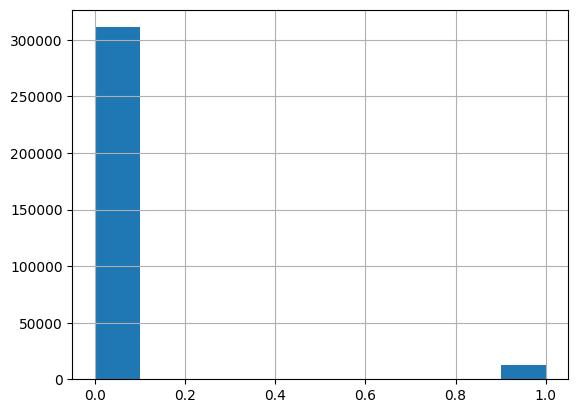

In [7]:
risk_factors['stroke'].hist()

### 1.2. Splitting into train and test set

In [45]:
from sklearn.model_selection import train_test_split
from collections import Counter

x_df = risk_factors.drop(columns=['stroke'])
y_df = risk_factors['stroke']

X_train, X_test, y_train, y_test = train_test_split(x_df, y_df, test_size=0.3, random_state=100)

print(f"Training target statistics: {Counter(y_train)}")
print(f"Testing target statistics: {Counter(y_test)}")

Training target statistics: Counter({0.0: 217791, 1.0: 8791})
Testing target statistics: Counter({0.0: 93337, 1.0: 3770})


### 1.3. Comparing imbalanced and balanced performance
Comparing the perfomance of the imbalanced and balanced dataset using a Decision Tree algorithm.

In [51]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report
from scikitplot.metrics import plot_roc
from scikitplot.metrics import plot_precision_recall
from scikitplot.metrics import plot_cumulative_gain
from scikitplot.metrics import plot_lift_curve
from numpy import argmax


def build_and_test(X_tr, X_te, y_tr, y_te, class_weight=None, threshold=False):   
  # build and plot PCA
  pca = PCA(n_components=2)
  pca.fit(X_tr)
  X_pca = pca.transform(X_tr)
  plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_tr, alpha=0.7)
  plt.show()
  
  # build and fit the model
  if class_weight:
      model = DecisionTreeClassifier(class_weight=class_weight)
  else:
      model = DecisionTreeClassifier()
  model.fit(X_tr, y_tr)
  
  # Test the model
  y_pred = model.predict(X_te)
  print('Precision score %s' % precision_score(y_te, y_pred))
  print('Recall score %s' % recall_score(y_te, y_pred))
  print('F1-score score %s' % f1_score(y_te, y_pred))
  print('Accuracy score %s' % accuracy_score(y_te, y_pred))
  
  y_score = model.predict_proba(X_te)
  fpr0, tpr0, thresholds = roc_curve(y_te, y_score[:, 1])
  roc_auc0 = auc(fpr0, tpr0)
  
  # calculate the best threshold
  best_threshold = None
  if threshold:
    J = tpr0 - fpr0
    ix = argmax(J) # take the value which maximizes the J variable
    best_threshold = thresholds[ix]
    # adjust score according to threshold.
    y_score = np.array([[1, y[1]] if y[0] >= best_threshold else [0, y[1]] for y in y_score])
    
  # plot metrics 
  plot_roc(y_te, y_score)
  plt.show()
  
  plot_precision_recall(y_te, y_score)
  plt.show()
  
  plot_cumulative_gain(y_te, y_score)
  plt.show()
  
  plot_lift_curve(y_te, y_score)
  plt.show()
  
  # Print a classification report
  print(classification_report(y_te,y_pred))
  return roc_auc0,fpr0,tpr0, best_threshold

**Imbalanced dataset performance**

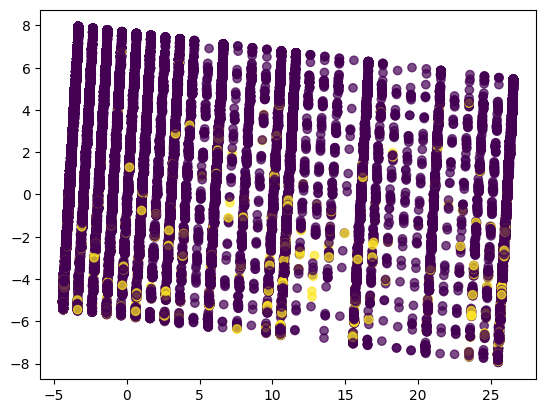

Precision score 0.1432225063938619
Recall score 0.04456233421750663
F1-score score 0.06797491401982603
Accuracy score 0.9525574881316486


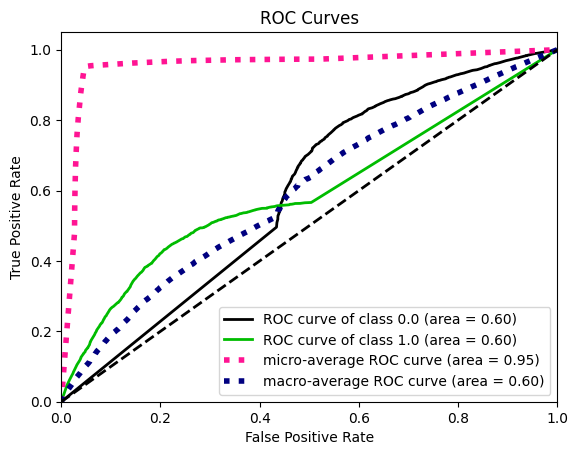

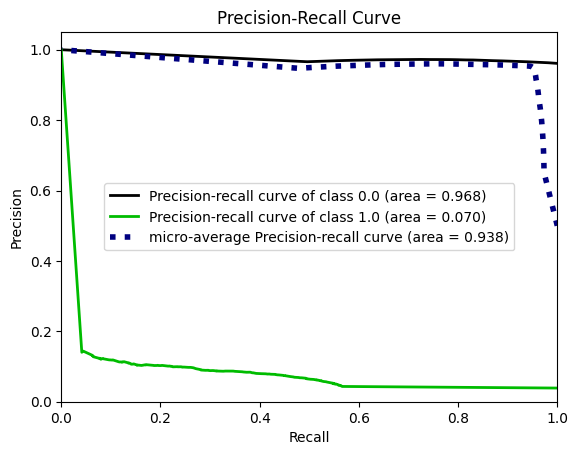

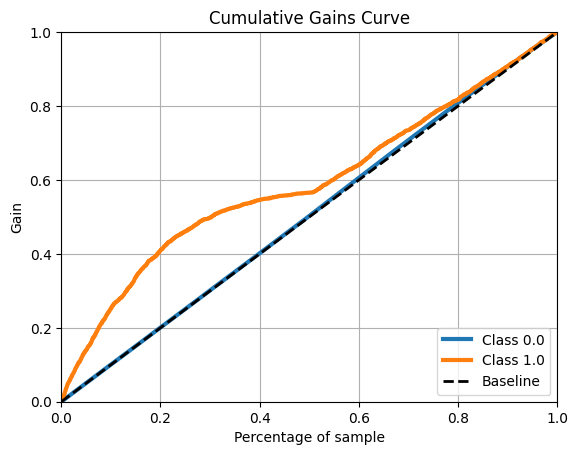

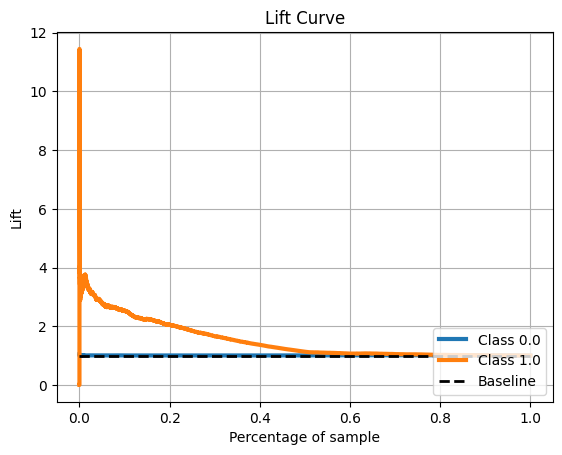

              precision    recall  f1-score   support

         0.0       0.96      0.99      0.98     93337
         1.0       0.14      0.04      0.07      3770

    accuracy                           0.95     97107
   macro avg       0.55      0.52      0.52     97107
weighted avg       0.93      0.95      0.94     97107



In [52]:
roc_auc_imb, fpr_imb, tpr_imb, _ = build_and_test(X_train, X_test, y_train, y_test)

**Random under-sampling**

Perform under-sampling

In [54]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=42)
X_rus, y_rus = rus.fit_resample(X_train, y_train)

print('Training target statistics:', Counter(y_rus))
print('Testing target statistics:', Counter(y_test))

Training target statistics: Counter({0.0: 8791, 1.0: 8791})
Testing target statistics: Counter({0.0: 93337, 1.0: 3770})


Performance

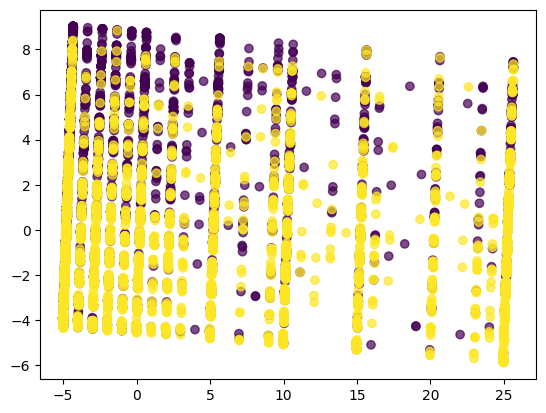

Precision score 0.0740823278469326
Recall score 0.6172413793103448
F1-score score 0.13228731417526504
Accuracy score 0.6856354330789748


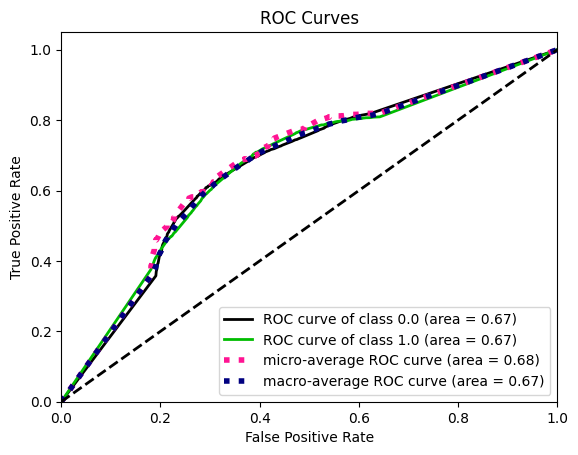

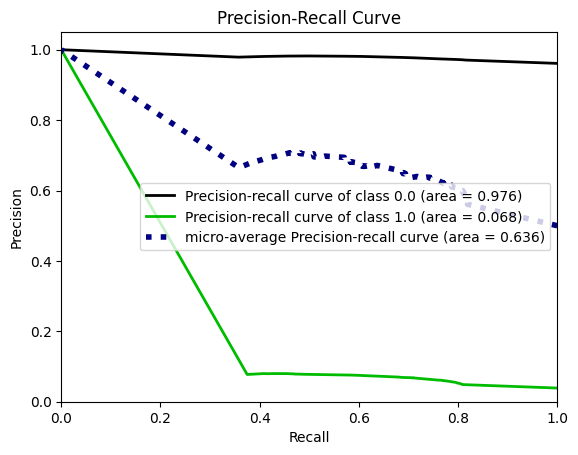

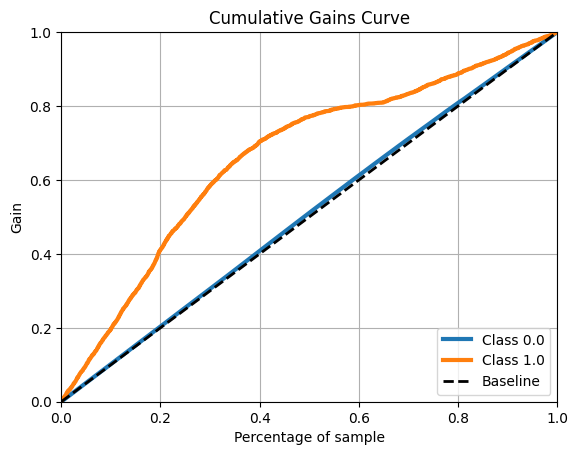

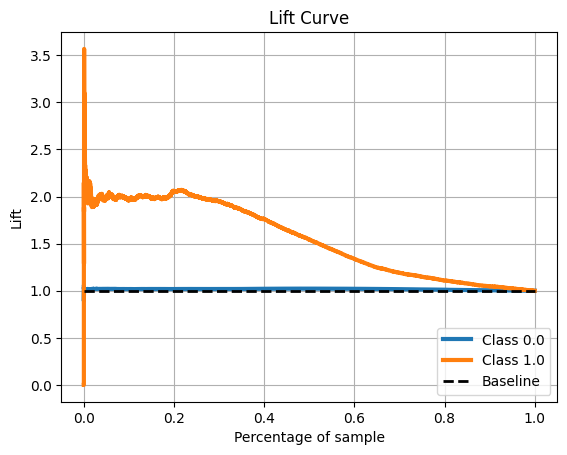

              precision    recall  f1-score   support

         0.0       0.98      0.69      0.81     93337
         1.0       0.07      0.62      0.13      3770

    accuracy                           0.69     97107
   macro avg       0.53      0.65      0.47     97107
weighted avg       0.94      0.69      0.78     97107



In [55]:
roc_auc_rus, fpr_rus, tpr_rus , _ = build_and_test(X_rus, X_test, y_rus, y_test)

**NearMiss under-sampling**

In [56]:
from collections import Counter
from imblearn.under_sampling import NearMiss
from numpy import where

# define the undersampling method
undersample = NearMiss(version=3, n_neighbors_ver3=3)
# transform the dataset
X_nm, y_nm = undersample.fit_resample(X_train, y_train)
# summarize the new class distribution
print('Training target statistics:', Counter(y_nm))
print('Testing target statistics:', Counter(y_test))

Training target statistics: Counter({0.0: 8791, 1.0: 8791})
Testing target statistics: Counter({0.0: 93337, 1.0: 3770})


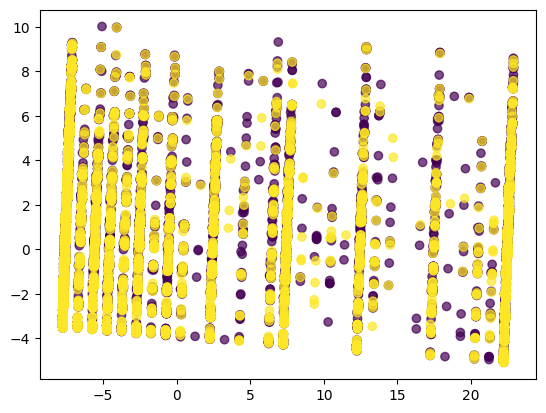

Precision score 0.04632806415626513
Recall score 0.5838196286472148
F1-score score 0.0858441077244096
Accuracy score 0.5172644608524617


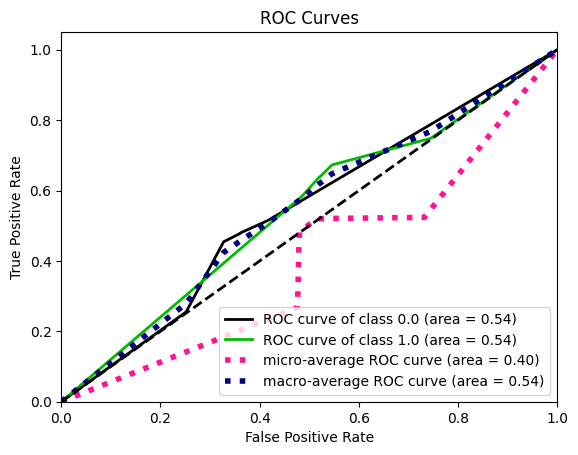

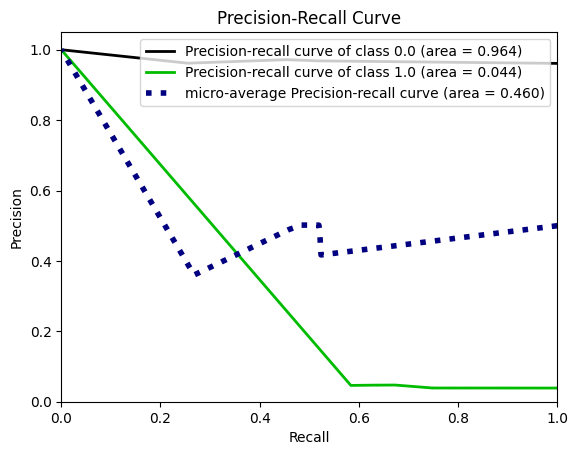

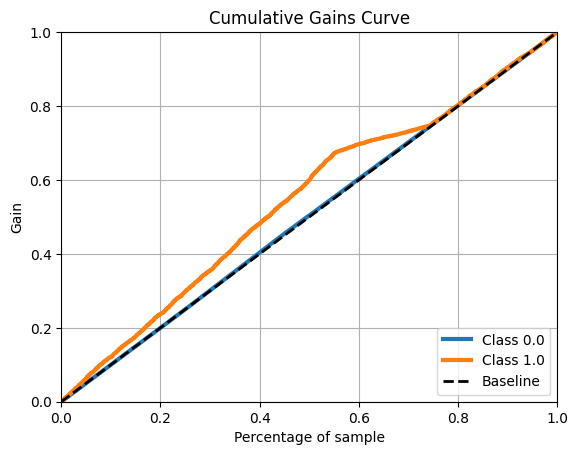

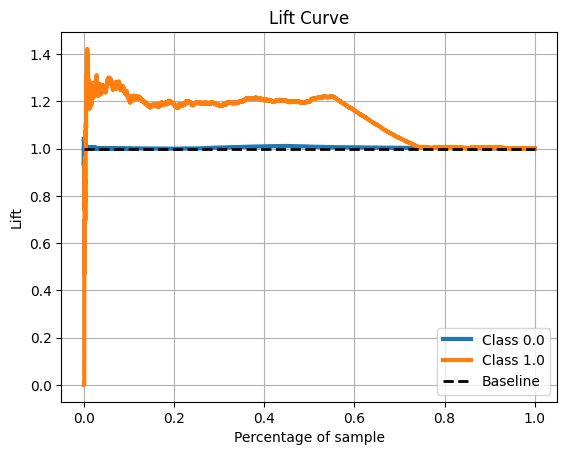

              precision    recall  f1-score   support

         0.0       0.97      0.51      0.67     93337
         1.0       0.05      0.58      0.09      3770

    accuracy                           0.52     97107
   macro avg       0.51      0.55      0.38     97107
weighted avg       0.93      0.52      0.65     97107



In [57]:
roc_auc_nm, fpr_nm, tpr_nm , _ = build_and_test(X_nm, X_test, y_nm, y_test)

**Class weight**

In [58]:
n = Counter(y_train)
ratio = int(n[0]/n[1])
ratio, n

(24, Counter({0.0: 217791, 1.0: 8791}))

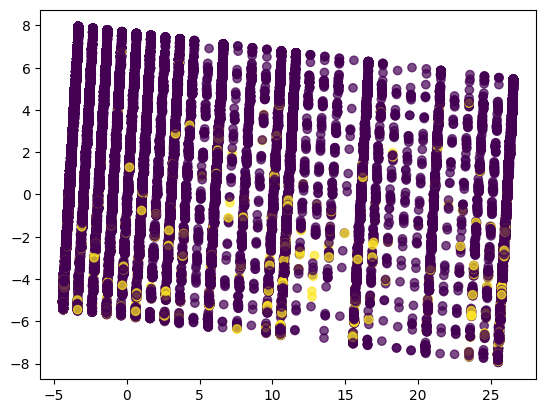

Precision score 0.07445792990590482
Recall score 0.43448275862068964
F1-score score 0.12712949668205983
Accuracy score 0.7683689126427549


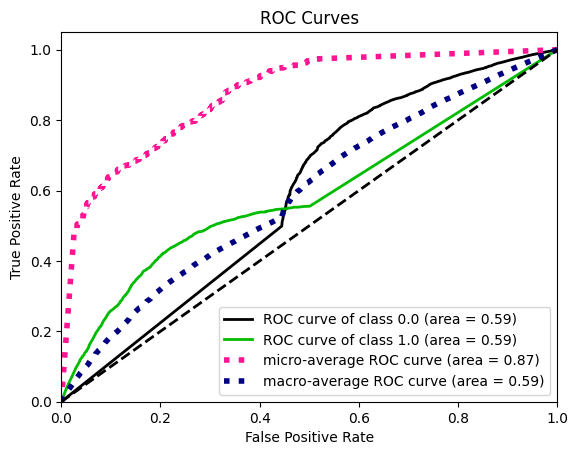

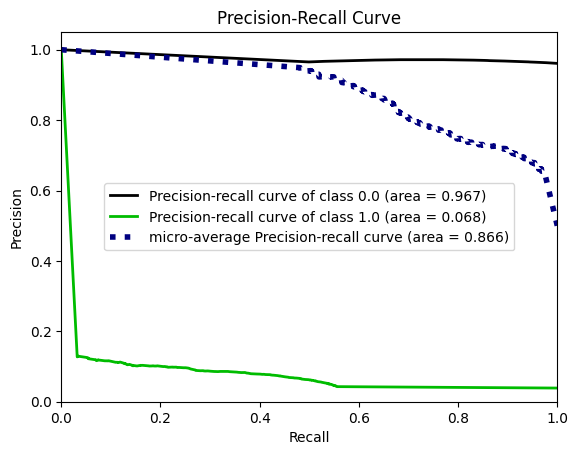

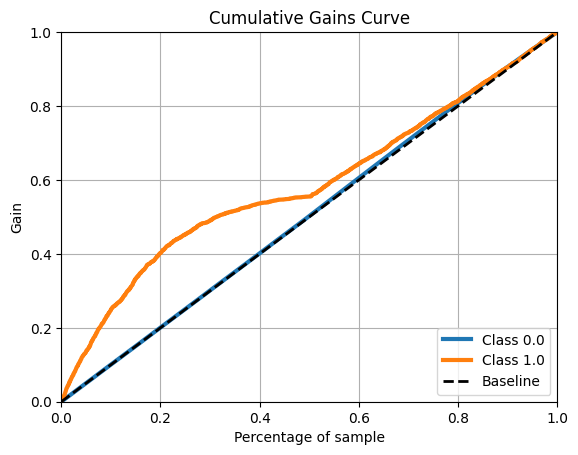

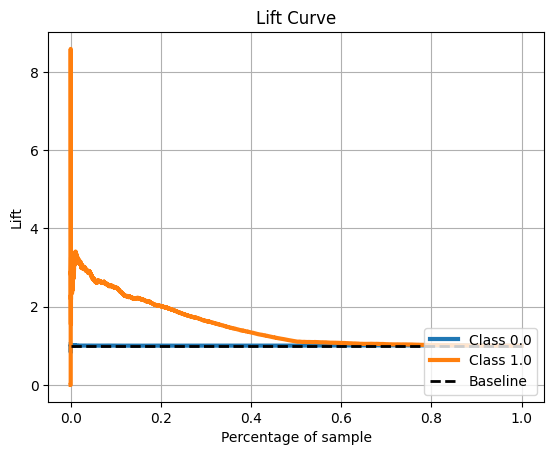

              precision    recall  f1-score   support

         0.0       0.97      0.78      0.87     93337
         1.0       0.07      0.43      0.13      3770

    accuracy                           0.77     97107
   macro avg       0.52      0.61      0.50     97107
weighted avg       0.94      0.77      0.84     97107



In [59]:
roc_auc_cw,fpr_cw,tpr_cw, _  = build_and_test(X_train, X_test, y_train, y_test, class_weight={0:1, 1:ratio})

**Comparing**

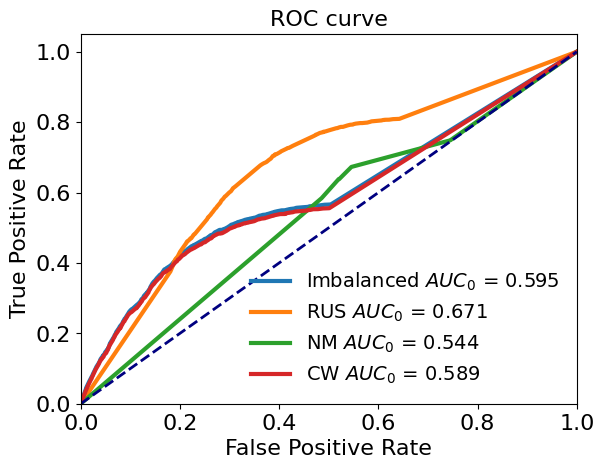

In [61]:
plt.plot(fpr_imb, tpr_imb, lw=3, label='Imbalanced $AUC_0$ = %.3f' % (roc_auc_imb))
plt.plot(fpr_rus, tpr_rus, lw=3, label='RUS $AUC_0$ = %.3f' % (roc_auc_rus))
plt.plot(fpr_nm, tpr_nm, lw=3, label='NM $AUC_0$ = %.3f' % (roc_auc_nm))
plt.plot(fpr_cw, tpr_cw, lw=3, label='CW $AUC_0$ = %.3f' % (roc_auc_cw))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()